<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Recap" data-toc-modified-id="Recap-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Recap</a></span></li><li><span><a href="#Chapter-Goals" data-toc-modified-id="Chapter-Goals-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Chapter Goals</a></span><ul class="toc-item"><li><span><a href="#Are-the-components-more-stationary-than-the-whole?" data-toc-modified-id="Are-the-components-more-stationary-than-the-whole?-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Are the components more stationary than the whole?</a></span><ul class="toc-item"><li><span><a href="#Import-data" data-toc-modified-id="Import-data-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Import data</a></span></li></ul></li><li><span><a href="#ADF-test-convenience-functions" data-toc-modified-id="ADF-test-convenience-functions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>ADF test convenience functions</a></span></li></ul></li><li><span><a href="#Run-Experiment" data-toc-modified-id="Run-Experiment-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Run Experiment</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Demo-the-model-function-and-plots" data-toc-modified-id="Demo-the-model-function-and-plots-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Demo the model function and plots</a></span></li></ul></li><li><span><a href="#Varying-the-lookback-periods" data-toc-modified-id="Varying-the-lookback-periods-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Varying the lookback periods</a></span></li><li><span><a href="#Varying-the-number-of-components" data-toc-modified-id="Varying-the-number-of-components-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Varying the number of components</a></span></li></ul></li><li><span><a href="#Evaluate-Results" data-toc-modified-id="Evaluate-Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluate Results</a></span><ul class="toc-item"><li><span><a href="#lookback-results" data-toc-modified-id="lookback-results-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>lookback results</a></span></li><li><span><a href="#number-of-component-results" data-toc-modified-id="number-of-component-results-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>number of component results</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#Resources-and-Citations" data-toc-modified-id="Resources-and-Citations-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Resources and Citations</a></span></li></ul></div>

In [11]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2

from IPython.display import display

# import standard libs
from pathlib import Path
import sys
import time
import os
from copy import copy

# get project dir
pp = Path(Path.cwd()).parts[:-1]
pdir = Path(*pp)
data_dir = pdir/'data'
script_dir = pdir / 'scripts' 
sys.path.append(script_dir.as_posix())

# import python scientific stack
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import pandas_datareader as pdr
import numpy as np
import sklearn.mixture as mix
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats
from numba import jit
import math

# import visual tools
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns
savefig_kwds=dict(dpi=300, bbox_inches='tight')

# import util libs
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from utils import cprint

# set globals
plt.style.use('seaborn-talk')
plt.style.use('bmh')
plt.rcParams['font.family'] = 'Bitstream Vera Sans'
#plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7

blue, gold, green, red, purple, brown = sns.color_palette('colorblind', 6)
nanex_colors = ("#f92b20", "#fe701b", "#facd1f", "#d6fd1c", "#65fe1b",
                "#1bfe42", "#1cfdb4", "#1fb9fa", "#1e71fb", "#261cfd")
nanex_cmap = mpl.colors.ListedColormap(nanex_colors,name='nanex_cmap')
RANDOM_STATE = 777

print()
%watermark -p pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn,plotnine

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2019-01-04T13:44:45-07:00

CPython 3.7.1
IPython 6.5.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.19.11-041911-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

pandas 0.23.4
pandas_datareader 0.7.0
numpy 1.15.4
sklearn 0.20.2
statsmodels 0.9.0
scipy 1.1.0
matplotlib 3.0.2
seaborn 0.9.0
plotnine 0.5.1


## Recap

In the last chapter we went through a demonstration of the expectation-maximization algorithm and how to use the scikit-learn Gaussian Mixture implementatation.

## Chapter Goals

In a previous lecture a student asked me if the Gaussian Mixture components are more stationary than the main dataset. Hopefully this notebook will be able to answer that question.

### Are the components more stationary than the whole?

Briefly we will examine if the component gaussian's distributions are more stationary than the entire dataset. To test this hypothesis we will use the `adfuller` test from statsmodels. This statistical test gives us insight into whether or not the data set has a unit-root. A unit-root implies a random-walk which is nonstationary. The `adfuller` test assumes there is a unit-root. If the test statistic is smaller than critical values (they are negative) and the p-value is really small there's a strong chance that our data is stationary and thus predictable.

#### Import data

In [6]:
infp = Path(data_dir/'tiingo_etf_returns_ending_2017-12-31.parq')
R = (pd.read_parquet(infp)
     .assign(year=lambda df: df.index.year)) # add year column for later conv.
cprint(R)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
               SPY     QQQ     TLT    GLD     EFA     EEM  year
date                                                           
2017-12-22 -0.0003 -0.0011  0.0014 0.0052  0.0026  0.0084  2017
2017-12-26 -0.0012 -0.0054  0.0030 0.0068 -0.0003 -0.0009  2017
2017-12-27  0.0005  0.0001  0.0129 0.0038  0.0019  0.0026  2017
2017-12-28  0.0021  0.0012 -0.0009 0.0051  0.0006  0.0068  2017
2017-12-29 -0.0038 -0.0062  0.0016 0.0065  0.0007  0.0047  2017
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3301 entries, 2004-11-19 to 2017-12-29
Data columns (total 7 columns):
SPY     3301 non-null float64
QQQ     3301 non-null float64
TLT     3301 non-null float64
GLD     3301 non-null float64
EFA     3301 non-null float64
EEM     3301 non-null float64
year    3301 no

In [7]:
sym = 'SPY' # example symbol
df = R.loc['2005':].copy() # use 2005 cutoff b/c it's first full year of data
s = df[sym].copy()
cprint(s)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
               SPY
date              
2017-12-22 -0.0003
2017-12-26 -0.0012
2017-12-27  0.0005
2017-12-28  0.0021
2017-12-29 -0.0038
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3272 entries, 2005-01-03 to 2017-12-29
Data columns (total 1 columns):
SPY    3272 non-null float64
dtypes: float64(1)
memory usage: 51.1 KB
None
-------------------------------------------------------------------------------



### ADF test convenience functions

In [41]:
adftest = sm.tsa.adfuller

def get_adf_result(X, test_label):
    res = adftest(X.ravel())
    res_cols = ['test_stat','pval','lag','nobs']
    s = pd.Series(res[:4], index=res_cols)
    s.name = test_label
    
    crit_values = pd.DataFrame.from_dict(res[-2], orient='index')[0]
    s = s.append(crit_values)
    return s

def combine_adf_results(agg_pdfs, x):

    sym_data_res = get_adf_result(x, 'all_data')
    
    results = []
    
    cols = ['all_data']
    for i,c in enumerate(agg_pdfs):
        label = f'component_{i}'
        cols.append(label)
        res = get_adf_result(c, label)
        results.append(res)

    res_df = pd.concat([sym_data_res]+results,axis=1)    
    res_df.columns = cols
    return res_df
    
def make_gmm(n_components, max_iter=150, random_state=RANDOM_STATE):
    """fn: create gmm object"""
    model_kwds = dict(n_components=n_components, 
                      max_iter=max_iter,
                      n_init=100,
                      random_state=RANDOM_STATE)

    gmm = mix.GaussianMixture(**model_kwds)
    return gmm

## Run Experiment

To answer this question we will observe how the adf results change as a function of the lookback periods and the number of components.

In [42]:
def run_model(lookback, n_components, n_split, max_iter=150, plot=True):
    """
    run model and output plots and results, save results to dict
    """
    
    np.random.seed(0)
    
    # stash data in lists
    preds = []
    pred_means = []
    pred_covs = []

    adf_tests = {}

    ### begin plot code ###
    colors = plt.cm.rainbow(np.linspace(0, 1, n_components))

    tscv = TimeSeriesSplit(n_splits=n_split, max_train_size=lookback)
    for i, (train, test) in enumerate(tscv.split(s)):

        tmp_train = s.iloc[train].values.reshape(-1,1) # temporary train data
        tmp_test = s.iloc[test].values.reshape(-1,1) # temporary test data

        gmm = make_gmm(n_components, max_iter=max_iter)
        gmm.fit(tmp_train, s.iloc[train].index.values)

        hidden_states_prob = gmm.predict_proba(tmp_train)
        hidden_states = gmm.predict(tmp_train)

        state_df = (s.iloc[train].to_frame()
                    .assign(component=pd.Categorical(hidden_states))
                    .assign(mkt_cret=lambda df: df[sym].cumsum())
                    .reset_index())

        # reshape observed returns
        x = state_df[sym].sort_values().values.reshape(-1,1)

        # agg pdfs into list
        agg_pdfs = [w * stats.norm.pdf(x, mu, sd) 
                    for mu, sd, w in zip(gmm.means_, np.sqrt(gmm.covariances_), gmm.weights_)]

        adf_test = combine_adf_results(agg_pdfs, x)
        adf_tests[i] = adf_test
        
        if plot:
            print('-'*55)
            print(f'split: {i}')
            display(adf_test)


            fig, ax = plt.subplots(figsize=(10,7))
            # plot observed data distribution #and a single component gaussian fit aka norm fit
            sns.distplot(x, ax=ax, hist=True, hist_kws=dict(alpha=0.25),
                         kde=True, kde_kws=dict(lw=4, label='spy-kde'),
                         label=sym)

            # plot component gaussians  
            for i in range(len(agg_pdfs)): ax.plot(x, agg_pdfs[i], ls='--', label=f'Gaussian {i}');  

            # ax.plot(x, summed_density, color='k')  
            plt.title(f'{sym} kde with component densities')
            plt.legend()    
        
    return adf_tests

#### Demo the model function and plots

-------------------------------------------------------
split: 0


,all_data,component_0,component_1,component_2
test_stat,4.2276,4.8208,-2.2095,"-56,133,212,211,725,352.0000"
pval,1.0000,1.0000,0.2028,0.0000
lag,7.0000,13.0000,9.0000,0.0000
nobs,244.0000,238.0000,242.0000,251.0000
1%,-3.4574,-3.4581,-3.4577,-3.4567
5%,-2.8735,-2.8738,-2.8736,-2.8731
10%,-2.5731,-2.5733,-2.5732,-2.5729


-------------------------------------------------------
split: 1


,all_data,component_0,component_1,component_2
test_stat,2.0618,-3.3261,4.4599,-4.8251
pval,0.9987,0.0138,1.0000,0.0000
lag,16.0000,13.0000,8.0000,16.0000
nobs,235.0000,238.0000,243.0000,235.0000
1%,-3.4585,-3.4581,-3.4576,-3.4585
5%,-2.8739,-2.8738,-2.8735,-2.8739
10%,-2.5734,-2.5733,-2.5731,-2.5734


-------------------------------------------------------
split: 2


,all_data,component_0,component_1,component_2
test_stat,2.6639,-2.4695,-5.3658,-2.6957
pval,0.9991,0.1231,0.0000,0.0748
lag,16.0000,8.0000,15.0000,15.0000
nobs,235.0000,243.0000,236.0000,236.0000
1%,-3.4585,-3.4576,-3.4584,-3.4584
5%,-2.8739,-2.8735,-2.8739,-2.8739
10%,-2.5734,-2.5731,-2.5733,-2.5733


-------------------------------------------------------
split: 3


,all_data,component_0,component_1,component_2
test_stat,3.3306,-2.3412,-5.4710,-0.6436
pval,1.0000,0.1590,0.0000,0.8608
lag,8.0000,9.0000,13.0000,15.0000
nobs,243.0000,242.0000,238.0000,236.0000
1%,-3.4576,-3.4577,-3.4581,-3.4584
5%,-2.8735,-2.8736,-2.8738,-2.8739
10%,-2.5731,-2.5732,-2.5733,-2.5733


-------------------------------------------------------
split: 4


,all_data,component_0,component_1,component_2
test_stat,2.0205,-2.4567,-2.5217,1.8389
pval,0.9987,0.1264,0.1103,0.9984
lag,14.0000,11.0000,10.0000,6.0000
nobs,237.0000,240.0000,241.0000,245.0000
1%,-3.4582,-3.4579,-3.4578,-3.4573
5%,-2.8738,-2.8737,-2.8736,-2.8734
10%,-2.5733,-2.5732,-2.5732,-2.5731


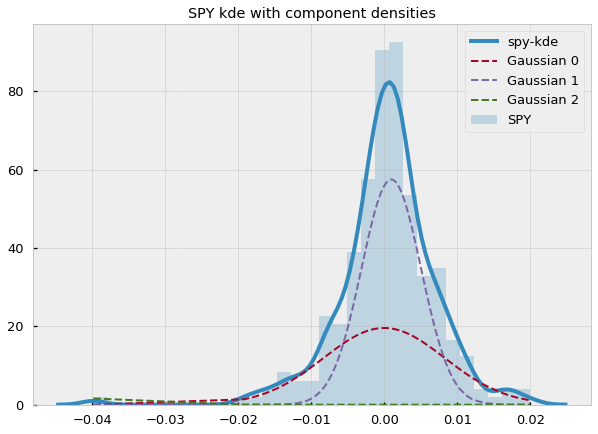

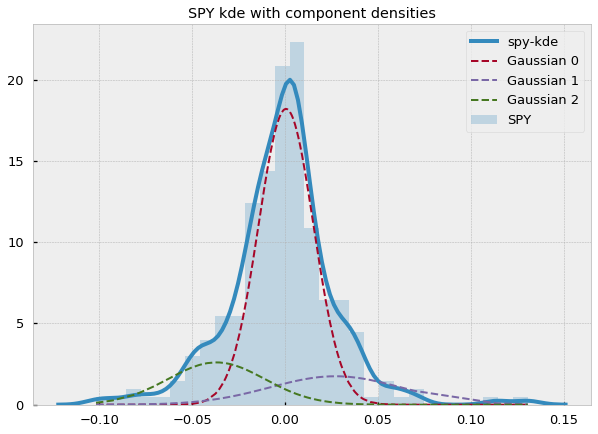

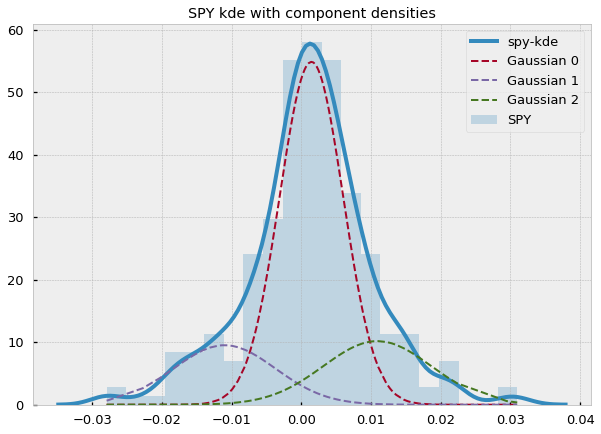

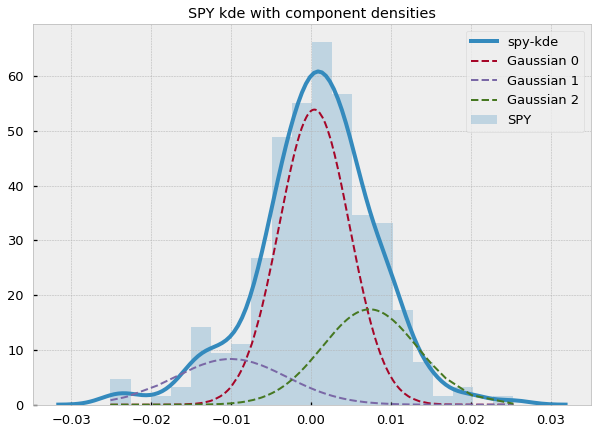

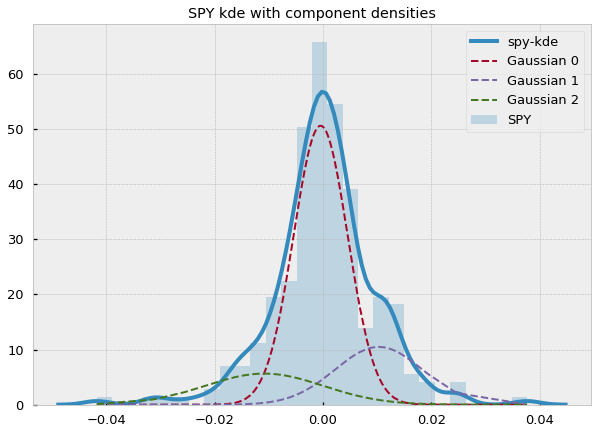

In [43]:
lookback = 252
n_components = 3
n_split = 5

demo_results = run_model(lookback, n_components, n_split)

### Varying the lookback periods

In [44]:
lookback_results = {}

lookbacks = [30,60,90,252,504]
n_components = 3
n_split = 5

for look in lookbacks:
    look_result = run_model(look, n_components, n_split, plot=False)
    lookback_results[look] = look_result

### Varying the number of components

In [45]:
n_mix_results = {}

n_components = [2,3,4,5,7,10]
lookback = 252
n_split = 5

for n in n_components:
    n_result = run_model(lookback, n, n_split, plot=False)
    n_mix_results[n] = n_result

## Evaluate Results

To do this we will look at a description of the pvalues for each parameter combo in comparison to the training data's adf result.

In [65]:
def compute_results(result_dict):
    mean_pval_all_data = {}
    mean_pval_components = {}

    for k in result_dict.keys():
        split_dict = result_dict[k]
        pval_all_data = [split['all_data'].loc['pval'] 
                         for split in split_dict.values()]
        mean_pval_all_data[k] = np.mean(pval_all_data)

        pval_components = [split.drop('all_data',axis=1).loc['pval'].mean()
                           for split in split_dict.values()]
        mean_pval_components[k] = np.mean(pval_components)
    
    df1 = (pd.DataFrame.from_dict(mean_pval_all_data, orient='index')
           .rename(columns={0:'all_data'}))
    df2 = (pd.DataFrame.from_dict(mean_pval_components, orient='index')
           .rename(columns={0:'components'}))
    
    return (pd.concat([df1,df2],axis=1)
            .assign(diff=lambda df: df.all_data - df.components))

### lookback results

In [71]:
ldf = compute_results(lookback_results)
ldf.loc['total_mean'] = ldf.mean(axis=0)
ldf

,all_data,components,diff
30,0.4821,0.3420,0.1401
60,0.5996,0.3758,0.2238
90,0.8066,0.2496,0.5570
252,0.9993,0.3113,0.6880
504,0.9995,0.4670,0.5325
total_mean,0.7774,0.3491,0.4283


We can see that as more data is included in the lookback or training period, the less stationary the training dataset is.

Across all the lookbacks on average the components tend to be *more* stationary than the main dataset.

### number of component results

In [72]:
ndf = compute_results(n_mix_results)
ndf.loc['total_mean'] = ndf.mean(axis=0)
ndf

,all_data,components,diff
2,0.9993,0.5745,0.4248
3,0.9993,0.3113,0.6880
4,0.9993,0.1090,0.8903
5,0.9993,0.1197,0.8797
7,0.9993,0.2443,0.7550
10,0.9993,0.2580,0.7413
total_mean,0.9993,0.2695,0.7298


We can see that holding the lookback constant at 252 the *nonstationarity* of the training dataset remains very high while on average, it appears like more components *increases the stationarity* or *lowers the pvalue*. Let's try it with a `60` day lookback for comparison.

In [75]:
n_mix_results2 = {}

n_components = [2,3,4,5,7,10]
lookback = 60
n_split = 5

for n in n_components:
    n_result = run_model(lookback, n, n_split, plot=False)
    n_mix_results2[n] = n_result
    
ndf2 = compute_results(n_mix_results2)
ndf2.loc['total_mean'] = ndf2.mean(axis=0)
ndf2    

,all_data,components,diff
2,0.5996,0.6343,-0.0347
3,0.5996,0.3758,0.2238
4,0.5996,0.2814,0.3182
5,0.5996,0.2468,0.3528
7,0.5996,0.3288,0.2708
10,0.5996,0.2796,0.3200
total_mean,0.5996,0.3578,0.2418


The results are mostly similar to what we observed with the longer lookback except the impact of the number components is less.

## Conclusions

Note that this is a crude way to answer the question. We can see that the component pvals can vary a good amount.

In [85]:
n_mix_results[10][0].drop('all_data',axis=1).loc['pval'].describe()

count   10.0000
mean     0.2902
std      0.3708
min      0.0000
25%      0.0009
50%      0.1522
75%      0.4439
max      1.0000
Name: pval, dtype: float64

In [82]:
lookback_results[60][2].drop('all_data',axis=1).loc['pval'].describe()

count   3.0000
mean    0.2403
std     0.4106
min     0.0000
25%     0.0033
50%     0.0066
75%     0.3605
max     0.7144
Name: pval, dtype: float64

However, in aggregate I think we can say that the components are indeed more stationary than the dataset they are drawn from as computed by the `adfuller` test.

## Resources and Citations

None.